## **___TL;DR Version (Short Demo)___**

In [1]:
from sklearn import datasets # iris dataset
from model import feedforward_neuralnet # model.py
from preprocessing import standard_scaler, train_test_split # utils.py
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Preprocessing & Train-test Split
iris = datasets.load_iris() # download Iris dataset
X, y = iris.data, iris.target # assign inputs and labels
X = standard_scaler(X) # scale features in X to unit gaussian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10) # train-test split

 76%|███████▌  | 7555/10000 [00:45<00:14, 165.11it/s, loss=0.0393, train_acc=0.992, val_acc=1]


Early Stopping at Epoch: 7567
Training Finished
Training Accuracy Score: 99.17%
Validation Accuracy Score: 100.00%
Training Logs are saved as a CSV file.
Training Curves are saved as a PNG file.


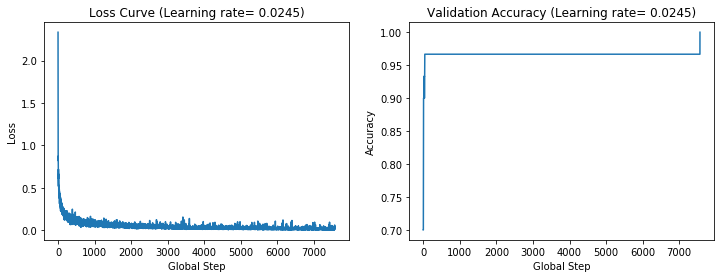

 76%|███████▌  | 7555/10000 [01:00<00:19, 125.91it/s, loss=0.0393, train_acc=0.992, val_acc=1]

In [3]:
# model configuration
model_a_configs = {'X_train':X_train,
                   'y_train':y_train,
                   'X_test':X_test,
                   'y_test':y_test,
                   'layer_dims':[4, 64, 64, 3], # layer dimensions
                   'activation':'relu', # activation function in hidden layer
                   'weight_init':'he_normal', # weight initialization method
                   'dropout_rate':0.5, # (1-keep_prob)
                   'learning_rate':0.0245, 
                   'num_steps':10000,
                   'early_stopping':True}

model_a = feedforward_neuralnet(**model_a_configs)

##### __***That's it! We have a trained a simple feed-forward neural network which can generalize into the validation set. (End Of Demo)***__

## Other Stuff We Can Do With the Trained Model

Calling `feedforward_neuralnet()` method also returns a `model` dictionary, containing model parameters and configurations.

```python
def feedforward_neuralnet(X_train, y_train, X_test, y_test, layer_dims,
                          activation='sigmoid', weight_init='glorot_uniform',
                          dropout_rate=None, learning_rate=0.0495, num_steps=3000, 
                          early_stopping=True):
    ...
    return model
```

Here are available keys found in the `model` dictionary:

In [4]:
model_a.keys()

dict_keys(['params', 'losses', 'training_accuracy', 'validation_accuracy', 'layer_dims', 'activation', 'weight_init', 'dropout_rate', 'learning_rate', 'best_epoch'])

The model weights are stored in `model['params']` 

In [5]:
for k, v in model_a['params'].items():
    print('Param: {}, Weights shape: {}'.format(k, v.shape))

Param: b1, Weights shape: (1, 64)
Param: W1, Weights shape: (4, 64)
Param: b2, Weights shape: (1, 64)
Param: W2, Weights shape: (64, 64)
Param: b3, Weights shape: (1, 3)
Param: W3, Weights shape: (64, 3)


If we want to make predictions after training, we can make predictions as long as we have the model in memory. This is possible by calling `model_predict()` method in `nn_utils.py`

```python
def model_predict(X, y, model):
    ...
    return preds, acc
```

In [6]:
from utils import model_predict # nn_utils.py

preds, acc = model_predict(X_test, y_test, model_a)

preds.shape, acc, preds, y_test

Accuracy: 1.0


((30,),
 1.0,
 array([1, 1, 2, 0, 2, 0, 1, 1, 2, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 0, 0, 1,
        0, 2, 2, 2, 1, 0, 2, 0]),
 array([1, 1, 2, 0, 2, 0, 1, 1, 2, 2, 0, 1, 2, 2, 1, 1, 2, 0, 2, 0, 0, 1,
        0, 2, 2, 2, 1, 0, 2, 0]))

Or you can also use `predict()` method in `nn_utils.py`

```python
def predict(X, y, params, activation):
    ...
    return acc
```

The former returns both prediction vector `preds` and accuracy score `acc`, while the latter only returns accuracy score `acc`

In [7]:
from utils import predict # nn_utils.py

acc = predict(X_test, y_test, model_a['params'], model_a['activation'])

acc

1.0

## How to Create More Models

To create another model and store it in memory:

1. create a new model config dictionary
2. pass the dictionary as `**kwargs` to `feedforward_neuralnet()`
3. call the `feedforward_neuralnet()` method and assign it to a variable

In [ ]:
# model configuration
model_b_configs = {'X_train':X_train,
                   'y_train':y_train,
                   'X_test':X_test,
                   'y_test':y_test,
                   'layer_dims':[4, 14, 8, 3], # layer dimensions
                   'activation':'relu', # activation function in hidden layer
                   'weight_init':'glorot_uniform', # weight initialization method
                   'dropout_rate':0.25, # (1-keep_prob)
                   'learning_rate':0.0045, 
                   'num_steps':10000,
                   'early_stopping':True}

model_b = feedforward_neuralnet(**model_a_configs)

## Under the Hood: How It Works

### 0. The Crux of the Neural Network

The essence of the neural network is found in `feedforward_neuralnet()` main function in `model.py`.

```python
from model import feedforward_neuralnet
```

There are 6 main steps:
1. Model Building
2. Forward Propagation
3. Loss Calculation
4. Backpropagation by Gradient Descent
5. Parameter Updates
6. Accuracy Calculation

```python

def feedforward_neuralnet(X_train, y_train, X_test, y_test, layer_dims,
                          activation='sigmoid', weight_init='glorot_uniform',
                          dropout_rate=None, learning_rate=0.0495, num_steps=3000, 
                          early_stopping=True):
    ...
    params = global_param_init(layer_dims, weight_init) # step 1
    for i in t: # Training loop
        probs, caches = model_forward(X_train, params, activation, dropout_rate) # step 2
        loss = cat_xentropy_loss(probs, y_train) # step 3
        grads = model_backward(probs, y_train, caches, activation, dropout_rate) # step 4
        params = update_params(params, grads, learning_rate) # step 5
        train_acc = predict(X_train, y_train, params, activation) # step 6
        val_acc = predict(X_test, y_test, params, activation)
    ...
```

A breakdown of the steps is as follows:

### 1. Model Building

```python
from utils import global_param_init
params = global_param_init(layer_dims, weight_init) # initialize weights
```

Which calls `global_param_init()` method in `nn_utils.py`

```python
def global_param_init(layer_dims, weight_init):
    ...
    return params
```

### 2. Forward Propagation

```python
from layers import model_forward
probs, caches = model_forward(X_train, params, activation, dropout_rate) # forward propagation
```

Which calls `model_forward()` method in `layers.py`

```python
def model_forward(X, params, activation, dropout_rate=None):
    ...
    return probs, caches
```

### 3. Loss Calculation

```python
from metrics import cat_xentropy_loss
loss = cat_xentropy_loss(probs, y_train) # calculate loss
```

Which is a categorical cross-entropy loss found in `cat_xentropy_loss()` in `metrics.py`

```python
def model_forward(X, params, activation, dropout_rate=None):
    ...
    return probs, caches
```

### 4. Backpropagation

```python
from layers import model_backward
grads = model_backward(probs, y_train, caches, activation, dropout_rate) # step 5
```

Which calls `model_backward()` method in `layers.py`

```python
def model_backward(probs, y, caches, activation, dropout_rate=None):
    ...
    return grads
```

### 5. Weight Updates

```python
from utils import update_params
params = update_params(params, grads, learning_rate) # step 6
```

Which calls `update_params()` method in `nn_utils.py`

```python
def update_params(params, grads, learning_rate):
    ...
    return params
```

### 6. Calculate Training and Validation Accuracy

```python
from utils import predict
train_acc = predict(X_train, y_train, params, activation) # training accuracy
val_acc = predict(X_test, y_test, params, activation) # testing accuracy
```

Which calls `predict()` method in `nn_utils.py`

```python
def predict(X, y, params, activation):
    ...
    return acc
```

That's it!

# APPENDIX

### Overview of other functions found in `layers.py`

```python
def dropout(A, dropout_rate):
    """Dropout forward propagation with dropout mask returned."""
    ...
    return A, dropout_mask

def dropout_backward(dA, dropout_mask, dropout_rate):
    """Dropout backpropagation which scales up un-dropped activation signals"""
    ...
    return dA * dropout_mask / (1.0 - dropout_rate)

def dense_forward(A, W, b):
    """Dense (fully-connected) layer forward propagation."""
    ...
    return Z, cache

def dense_backward(dZ, cache):
    """Dense (fully-connected) layer backpropagation."""
    ...
    return dA_prev, dW, db

def layer_forward(A_prev, W, b, activation, dropout_rate=None):
    """Forward propagation of a dense layer with an activation function of choice."""
    ...
    return A, cache

def layer_backward(dA, cache, activation, dropout_rate=None):
    """Backpropagation of a dense layer with an activation function of choice."""
    ...
    return dA_prev, dW, db
```

### Overview of activations in `activations.py`

```python
def sigmoid(Z):
    """Sigmoid forward propagation layer with cache returned."""  
    ...
    return A, cache

def sigmoid_backward(dA, cache):
    """Sigmoid backward propagation to return gradient w.r.t pre-activation matrix."""  
    ...
    return dZ

def relu(Z):
    """ReLU forward propagation layer with cache returned."""
    ...
    return A, cache

def relu_backward(dA, cache):
    """ReLU backward propagation to return gradient w.r.t pre-activation matrix.""" 
    ...
    return dZ

def softmax(Z):
    """Softmax forward propagation with cache returned."""
    ...
    return probs, cache

def softmax_backward(probs, y):
    """Softmax backward propagation to return gradient w.r.t pre-activation matrix."""
    ...
    return probs
```

### Overview of loss and accuracy metrics in `metrics.py`

```python
def cat_xentropy_loss(probs, y):
    """Returns categorical cross-entropy loss."""
    return np.mean(-np.log(probs[np.arange(y.shape[0]), y]))

def accuracy(preds, y):
    """Returns accuracy score given prediction probabilities and labels"""
    return np.sum(preds==y) / float(len(y))
```

### Overview of preprocessing functions in `preprocessing.py`

```python
def standard_scaler(X):
    """Scale features into a unit Gaussian."""
    return (X-np.mean(X, axis=0))/np.std(X, axis=0)
    
def one_hot_encoding(v):
    """One-hot encoding for categorical features."""
    return np.eye(len(np.unique(v)))[v]

def train_test_split(X, y, test_size, random_state=42):
    """Splits X and y into training and testing sets."""
    ...
    return X_train, X_test, y_train, y_test

def Kfold(X, n_splits, shuffle=False, random_state=42):
    """K-Fold Cross Validation in Numpy."""
    ...
    yield train_fold_idx, test_fold_idx
```

### Overview of other utility functions found in `utils.py`

```python
def log_csv(losses, train_accs, val_accs):
    """Record training data into a pandas dataframe then save it as a CSV file."""
    ...
    training_df.to_csv('logs.csv')
    print('Training Logs are saved as a CSV file.')

def plot(losses, val_accs, learning_rate):
    """Plots model loss and accuracy curves and save results as png."""
    ...
    fig.savefig('results.png')
    print('Training Curves are saved as a PNG file.')
```